In [66]:
import pandas as pd
import numpy as np
import logging
import seaborn as sns
from sklearn.model_selection import train_test_split

In [67]:
data = pd.read_excel('/home/kamau/Documents/personal/LION/data/ILTESTData_Raw_20240909.xlsx')

# data.to_csv(
    # '/home/kamau/Documents/personal/LION/data/clean_data.csv', index=False)

In [68]:
data.isna().sum()

Transaction ID             0
Class of Business          0
Sub-Class of Business      0
Transaction Type           0
Amount                   242
Currency                 695
Customer Name              0
Date                       0
Age                        0
Income                     0
Number of Claims           0
Account Balance            0
Default                    0
dtype: int64

In [4]:
data['Number of Claims'].nunique()
#generic customer_id (age+name)
data['customer_id'] = (data['Customer Name']) + data['Transaction ID'].astype(str)

#feature engineering
data['income_balance_ratio'] = data['Income']/data['Account Balance']

#imput Amount
data['Amount'] = data.groupby(['Class of Business', 'Transaction Type', 'Default'])['Amount'].transform(lambda x: x.fillna(x.mean()))

#change currency to KES/USD
current_fx = 130 #assumption here
data['Amount_converted'] = np.where(data['Currency'] == 'USD', 
                            data['Amount'] * current_fx,
                            data['Amount'] )

# data.isna().sum()

In [5]:
mis_val = data.isnull().sum()
mis_val_percent = 100 * data.isnull().sum() / len(data)

mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1).reset_index()
mis_val_table.columns = ['variable','missing','perc_missing']
cols_to_remove = []
thresh_hold = 90
for index, row in mis_val_table.iterrows():
    if row['perc_missing'] >= thresh_hold:
        cols_to_remove.append(row['variable'])

cols_to_remove

[]

In [6]:
data.head()

,Transaction ID,Class of Business,Sub-Class of Business,Transaction Type,Amount,Currency,Customer Name,Date,Age,Income,Number of Claims,Account Balance,Default,customer_id,income_balance_ratio,Amount_converted
0,1,Fire Domestic,Sub-Class H,Direct,2231.060606,USD,Anne Bailey,2024-02-13,71,62348,2,14817.511264,0,Anne Bailey1,4.207724,290037.878788
1,2,Miscellaneous,Sub-Class C,Outward Reinsurance,4000.000000,USD,Angelica Barker,2023-11-19,20,104117,2,825.826334,0,Angelica Barker2,126.076144,520000.000000
2,3,Aviation,Sub-Class H,Inward Reinsurance,2500.000000,KES,Kathleen Davis,2023-04-21,72,56679,5,18245.027158,0,Kathleen Davis3,3.106545,2500.000000
3,4,Fire Domestic,Sub-Class E,Inward Reinsurance,2418.348624,NaN,Andrea Barr,2023-03-30,73,99118,3,16685.578046,0,Andrea Barr4,5.940340,2418.348624
4,5,Fire Domestic,Sub-Class A,Direct,2500.000000,KES,Ryan Beck,2024-03-08,64,63888,3,-4544.867422,0,Ryan Beck5,-14.057176,2500.000000


In [7]:
data['Class of Business'].unique()

array(['Fire Domestic', 'Miscellaneous', 'Aviation', 'Engineering'],
      dtype=object)

In [8]:
# data.groupby(['Class of Business', 'Sub-Class of Business'])['Transaction Type'].nunique()

p = pd.crosstab([data['Class of Business'], data['Sub-Class of Business']],
            data['Transaction Type'], margins=True, margins_name='Total').reset_index()
p.drop(columns='Transaction Type')

KeyError: "['Transaction Type'] not found in axis"

In [ ]:
data.pivot_table(index=['Class of Business', 'Sub-Class of Business'],
                 columns='Transaction Type', aggfunc=len, fill_value=0)

Account Balance                     \
Transaction Type                                 Direct Inward Reinsurance   
Class of Business Sub-Class of Business                                      
Aviation          Sub-Class A                        20                 26   
                  Sub-Class B                        19                 13   
                  Sub-Class C                        25                 23   
                  Sub-Class D                        17                 27   
                  Sub-Class E                        25                 20   
                  Sub-Class F                        18                 17   
                  Sub-Class G                         9                 21   
                  Sub-Class H                        25                 22   
                  Sub-Class I                        26                 23   
Engineering       Sub-Class A                        17                 14   
                  Sub-Class B                        18                 19   
                  Sub-Class C                        22                 28   
                  Sub-Class D                        14                 17   
                  Sub-Class E                        23                 16   
                  Sub-Class F                        14                 24   
                  Sub-Class G                        15                 20   
                  Sub-Class H                        18                 24   
                  Sub-Class I                        17                 16   
Fire Domestic     Sub-Class A                        20                 13   
                  Sub-Class B                        14                 26   
                  Sub-Class C                        18                 12   
                  Sub-Class D                        22                 19   
                  Sub-Class E                        23                 21   
                  Sub-Class F                        18                 21   
                  Sub-Class G                        18                 19   
                  Sub-Class H                        29                 11   
                  Sub-Class I                        22                 15   
Miscellaneous     Sub-Class A                        20                 18   
                  Sub-Class B                        23                 15   
                  Sub-Class C                        13                 22   
                  Sub-Class D                        15                 11   
                  Sub-Class E                        16                 19   
                  Sub-Class F                        31                 24   
                  Sub-Class G                        12                 19   
                  Sub-Class H                        25                 16   
                  Sub-Class I                        16                 23   

                                                               Age  \
Transaction Type                        Outward Reinsurance Direct   
Class of Business Sub-Class of Business                              
Aviation          Sub-Class A                            24     20   
                  Sub-Class B                            25     19   
                  Sub-Class C                            16     25   
                  Sub-Class D                            19     17   
                  Sub-Class E                            19     25   
                  Sub-Class F                            18     18   
                  Sub-Class G                            15      9   
                  Sub-Class H                            17     25   
                  Sub-Class I                            21     26   
Engineering       Sub-Class A                            15     17   
                  Sub-Class B                            25     18   
                 

In [34]:
import pandas as pd
from optbinning import OptimalPWBinning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [9]:
model_data = pd.read_csv(
    '/home/kamau/Documents/personal/LION/outputs/data_for_modeling.csv')
model_data.head()

,Transaction ID,Class of Business,Sub-Class of Business,Transaction Type,Amount,Currency,Customer Name,Date,Age,Income,Number of Claims,Account Balance,Default,customer_id,income_balance_ratio,Amount_converted,inactive_days
0,1,Fire Domestic,Sub-Class H,Direct,2231.060606,USD,Anne Bailey,2024-02-13,71,62348,2,14817.511264,0,Anne Bailey1,4.207724,290037.878788,212
1,2,Miscellaneous,Sub-Class C,Outward Reinsurance,4000.000000,USD,Angelica Barker,2023-11-19,20,104117,2,825.826334,0,Angelica Barker2,126.076144,520000.000000,298
2,3,Aviation,Sub-Class H,Inward Reinsurance,2500.000000,KES,Kathleen Davis,2023-04-21,72,56679,5,18245.027158,0,Kathleen Davis3,3.106545,2500.000000,510
3,4,Fire Domestic,Sub-Class E,Inward Reinsurance,2418.348624,NaN,Andrea Barr,2023-03-30,73,99118,3,16685.578046,0,Andrea Barr4,5.940340,2418.348624,532
4,5,Fire Domestic,Sub-Class A,Direct,2500.000000,KES,Ryan Beck,2024-03-08,64,63888,3,-4544.867422,0,Ryan Beck5,-14.057176,2500.000000,188


In [10]:
model_data['Date'] = pd.to_datetime(model_data['Date'])
model_data['inactive_days'] = (pd.Timestamp(
    'today') - model_data['Date']).dt.days

<Axes: xlabel='inactive_days', ylabel='Density'>

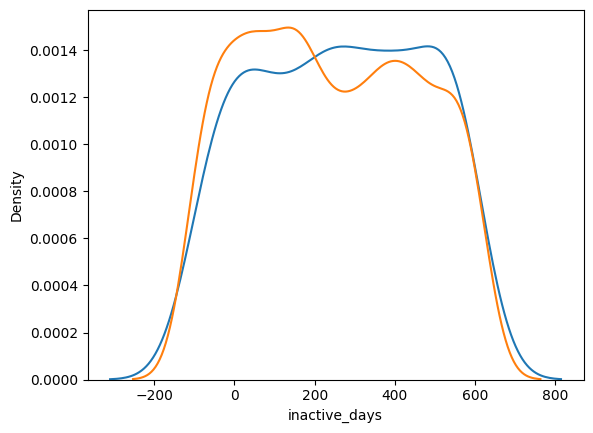

In [11]:
list_of_variables=['Class of Business', 'Transaction Type', 'Sub-Class of Business', 
                   'Amount', 'Income', 'Number of Claims', 'Account Balance', 'income_balance_ratio', 'inactive_days']

# model_data['Amount_converted'].describe()
sns.kdeplot(model_data.loc[model_data['Default'] == 1,
            'inactive_days'], label='Default == 1')
sns.kdeplot(model_data.loc[model_data['Default'] == 0,
            'inactive_days'], label='Default == 0')

In [12]:
model_data[model_data['Number of Claims'] <= 0]

,Transaction ID,Class of Business,Sub-Class of Business,Transaction Type,Amount,Currency,Customer Name,Date,Age,Income,Number of Claims,Account Balance,Default,customer_id,income_balance_ratio,Amount_converted,inactive_days
10,11,Fire Domestic,Sub-Class I,Inward Reinsurance,2418.348624,NaN,John Taylor,2023-05-26,51,132529,0,11121.382667,0,John Taylor11,11.916594,2418.348624,475
11,12,Fire Domestic,Sub-Class B,Direct,2500.000000,NaN,Ralph Wilcox DDS,2024-11-24,31,144713,0,10409.248278,0,Ralph Wilcox DDS12,13.902349,2500.000000,-73
12,13,Fire Domestic,Sub-Class I,Inward Reinsurance,4000.000000,NaN,Heather Roberts,2023-09-14,67,140048,0,840.489962,0,Heather Roberts13,166.626618,4000.000000,364
22,23,Engineering,Sub-Class I,Outward Reinsurance,2500.000000,NaN,Dr. Kevin Blevins,2023-12-05,71,36490,0,5104.803355,0,Dr. Kevin Blevins23,7.148170,2500.000000,282
25,26,Engineering,Sub-Class B,Direct,2200.000000,NaN,Christy Evans,2024-10-11,44,139066,0,18928.104892,0,Christy Evans26,7.347064,2200.000000,-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,1488,Aviation,Sub-Class E,Direct,2200.000000,USD,Stephanie Brown,2024-07-19,31,114368,0,11269.334745,0,Stephanie Brown1488,10.148603,286000.000000,55
2075,325,Engineering,Sub-Class B,Direct,2200.000000,KES,Emily Fuller,2024-09-16,29,128177,0,3062.430459,0,Emily Fuller325,41.854665,2200.000000,-4
2078,369,Fire Domestic,Sub-Class D,Outward Reinsurance,2500.000000,USD,James Prince,2023-08-17,46,137782,0,19591.520104,1,James Prince369,7.032737,325000.000000,392
2079,1820,Fire Domestic,Sub-Class G,Outward Reinsurance,2500.000000,USD,Stephanie Allison,2023-06-24,46,29495,0,365.049880,0,Stephanie Allison1820,80.797178,325000.000000,446


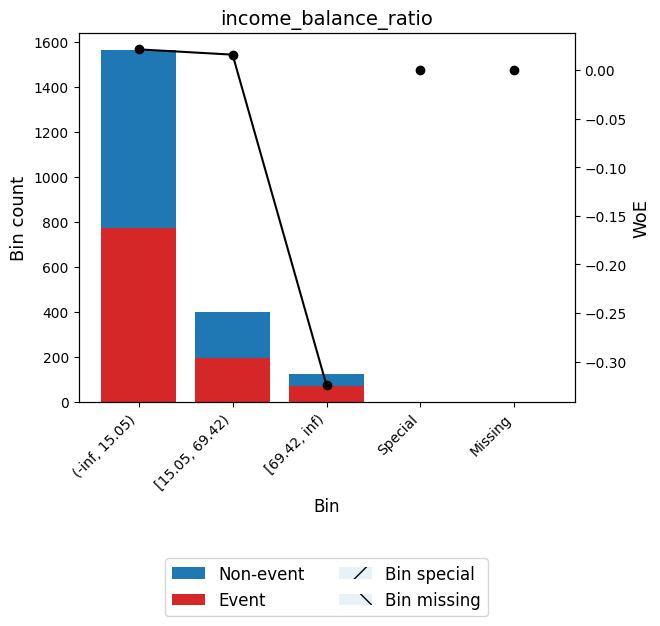

<Figure size 640x480 with 0 Axes>

In [76]:
from optbinning import OptimalBinning
from optbinning.scorecard import scorecard
from optbinning.binning import BinningProcess
from optbinning.scorecard import Scorecard
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import  LogisticRegression


variable = 'income_balance_ratio'
X = model_data[variable]
y = model_data['Default'].values

# Initialize the BinningProcess
opt = OptimalBinning(name=variable, dtype="numerical",
                     class_weight="balanced", solver="mip", monotonic_trend="auto_asc_desc")
opt.fit(X, y)
binning_table = opt.binning_table
binning_table.build()
binning_table.plot(show_bin_labels=True)
plt.savefig(
    '/home/kamau/Documents/personal/LION/outputs/income_balance_ratio_bins.png')

In [54]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 0.5},
    "quality_score": {"min": 0.0001}
}

list_variables = ['Class of Business', 'Transaction Type', 'Sub-Class of Business',
                     'Amount', 'Income', 'Number of Claims', 'Account Balance', 'income_balance_ratio', 'inactive_days',
                    #  'Amount_converted'
                     ]
binning_fit_params = {
    "Class of Business": {"dtype": "categorical", "solver": "mip", "class_weight": "balanced"},
    "Transaction Type": {"dtype": "categorical", "solver": "mip", "class_weight": "balanced"},
    "Sub-Class of Business": {"dtype": "categorical", "solver": "mip", "class_weight": "balanced"},
    "Amount": {"dtype": "numerical", "solver": "mip", "class_weight": "balanced"},
    "Income": {"dtype": "numerical", "solver": "mip", "class_weight": "balanced"},
    "Number of Claims": {"dtype": "numerical", "solver": "mip", "class_weight": "balanced"},
    "Account Balance": {"dtype": "numerical", "solver": "mip", "class_weight": "balanced"},
    "income_balance_ratio": {"dtype": "numerical", "solver": "mip", "class_weight": "balanced"},
    "inactive_days": {"dtype": "numerical", "solver": "mip", "class_weight": "balanced"},
    # "Amount_converted": {"dtype": "numerical", "solver": "mip", "class_weight": "balanced"}
}

scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 300}

X = model_data[list_variables]
y = model_data['Default'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

binning_process = BinningProcess(
    variable_names=list_variables, selection_criteria=selection_criteria, binning_fit_params=binning_fit_params)
lr = LogisticRegression(C=3, max_iter=1000)
binning_process.fit(X,y)
scorecard_full = Scorecard(binning_process=binning_process, estimator=lr,
                                  scaling_method=scaling_method, scaling_method_params=scaling_method_data,
                                  intercept_based=False,
                                  reverse_scorecard=False)
                                  
scorecard_full.fit(X_resampled, y_resampled)

Scorecard(binning_process=BinningProcess(binning_fit_params={'Account Balance': {'class_weight': 'balanced',
                                                                                 'dtype': 'numerical',
                                                                                 'solver': 'mip'},
                                                             'Amount': {'class_weight': 'balanced',
                                                                        'dtype': 'numerical',
                                                                        'solver': 'mip'},
                                                             'Class of Business': {'class_weight': 'balanced',
                                                                                   'dtype': 'categorical',
                                                                                   'solver': 'mip'},
                                                             'Income': {'class_weight': 'balanced',
                                                                        'dtype': 'numerical...
                                         selection_criteria={'iv': {'max': 0.5,
                                                                    'min': 0.02},
                                                             'quality_score': {'min': 0.0001}},
                                         variable_names=['Class of Business',
                                                         'Transaction Type',
                                                         'Sub-Class of '
                                                         'Business',
                                                         'Amount', 'Income',
                                                         'Number of Claims',
                                                         'Account Balance',
                                                         'income_balance_ratio',
                                                         'inactive_days']),
          estimator=LogisticRegression(C=3, max_iter=1000),
          scaling_method='min_max',
          scaling_method_params={'max': 300, 'min': 0})

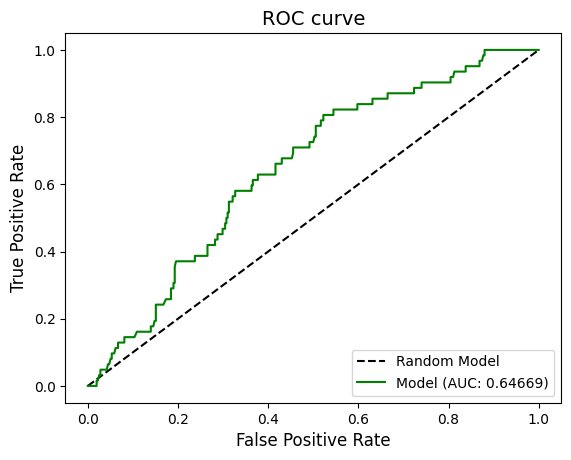

In [55]:
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
pred_proba = scorecard_full.predict_proba(X_test)[:, 1]
plot_auc_roc(y_test, pred_proba)

Text(0.5, 0.05, 'Prediction')

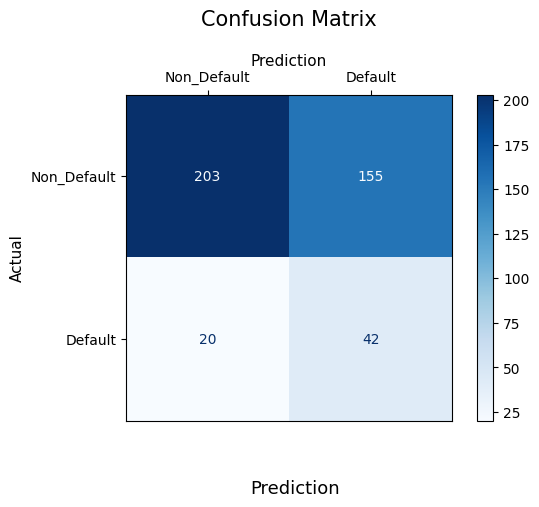

In [56]:
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
    preds = scorecard_full.predict(X_test)

    cm = confusion_matrix(y_test, preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, )

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
        'Non_Default', 'Default'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=15, pad=20)
    plt.xlabel('Prediction', fontsize=11)
    plt.ylabel('Actual', fontsize=11)
    # Customizations
    plt.gca().xaxis.set_label_position('top')
    plt.gca().xaxis.tick_top()
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

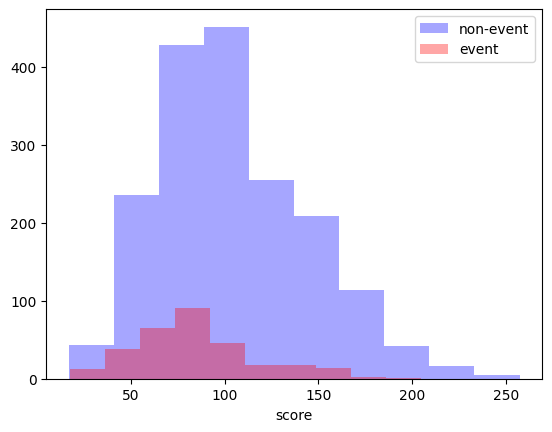

In [57]:
import matplotlib.pyplot as plt
score = scorecard_full.score(X)
mask = y == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

In [94]:
def get_policy_table(score_data, config_file):

    distrib_assumption = config_file['distribution_assumption']
    average_amount = config_file['average_amount']
    average_percentage_rate = config_file['average_percentage_rate']
    base_rate = config_file['base_rate']
    cost_of_bad_loan_multiplier = config_file['cost_of_bad_loan_multiplier']
    scores = score_data.groupby('customer_id').agg(
        score=pd.NamedAgg(column='overall_score', aggfunc='max'),
        default=pd.NamedAgg(column='Default', aggfunc='max')
    ).reset_index()

    scores = scores.sort_values(by='score', ascending=False)

    policy_tab = pd.DataFrame(list(distrib_assumption.items()), columns=[
        'risk_category', 'distribution'])

    policy_tab['cummulative_customers'] = policy_tab['distribution'].cumsum()

    policy_tab['cummulative_scores'] = round((
        policy_tab['cummulative_customers']/100)*scores[scores['score'] > 0].shape[0], 0)

    policy_tab['min_cut_off_score'] = None

    sorted_scores = sorted(scores[scores['score'] >
                                  0]['score'], reverse=True)
    policy_tab.loc[0, 'max_cut_off_score'] = scores['score'].max()

    for i in range(policy_tab.shape[0]):
        cut_off = int(policy_tab.loc[i, 'cummulative_scores'] - 1)
        min_score = sorted_scores[cut_off]
        policy_tab.loc[i, 'min_cut_off_score'] = min_score
        if i + 1 >= policy_tab.shape[0]:
            break
        policy_tab.loc[i + 1, 'max_cut_off_score'] = policy_tab.loc[i,
                                                                    'min_cut_off_score']

    policy_tab['max_cut_off_score'] = policy_tab['max_cut_off_score'].astype(
        int)
    policy_tab['max_cut_off_score'] = round(
        policy_tab['max_cut_off_score'].astype(int))
    policy_tab['min_cut_off_score'] = round(
        policy_tab['min_cut_off_score'].astype(int))

    def count_good_bads(row):
        scores_within_range = score_data[(score_data['overall_score'] > row['min_cut_off_score']) &
                                         (score_data['overall_score'] <= row['max_cut_off_score'])]
        count_goods = scores_within_range[scores_within_range['Default'] == 0]['Default'].count(
        )
        count_bads = scores_within_range[scores_within_range['Default'] == 1]['Default'].count(
        )
        return count_goods, count_bads

    policy_tab[['goods', 'bads']] = policy_tab.apply(
        count_good_bads, axis=1, result_type='expand')
    policy_tab['totals'] = policy_tab['bads'] + policy_tab['goods']
    policy_tab['bad_rate%'] = round(
        policy_tab['bads']*100/policy_tab['totals'], 1)
    for i in range(policy_tab.shape[0]):
        policy_tab.loc[i, 'bad_rate_at_cut_off%'] = round(
            sum(policy_tab.loc[0:i, 'bads'])*100/sum(policy_tab.loc[0:i, 'totals']), 1)
        policy_tab.loc[i, 'perc_contrast'] = round(
            policy_tab.loc[i, 'totals']*100/sum(policy_tab['totals']), 1
        )
        policy_tab.loc[i, 'cumu_perc_contrast'] = round(
            sum(policy_tab.loc[0:i, 'totals'])*100/sum(policy_tab['totals']), 1
        )
        policy_tab.loc[i, 'cumu_perc_goods'] = round(
            sum(policy_tab.loc[0:i, 'goods'])*100/sum(policy_tab['goods']), 1
        )
        policy_tab.loc[i, 'cumu_perc_bads'] = round(
            sum(policy_tab.loc[0:i, 'bads'])*100/sum(policy_tab['bads']), 1
        )

    policy_tab['average_amount'] = average_amount
    policy_tab['average_margin'] = round(average_percentage_rate-base_rate, 1)
    policy_tab['Interest Income'] = round(
        policy_tab['goods']*policy_tab['average_amount']*policy_tab['average_margin']/100, 0)

    policy_tab['Ave. Total Charge Off'] = round(
        policy_tab['average_amount']*cost_of_bad_loan_multiplier)
    policy_tab['Total Loss'] = round(
        policy_tab['bads']*policy_tab['average_amount'], 0)
    policy_tab['Gross Margin'] = policy_tab['Interest Income'] - \
        policy_tab['Total Loss']

    return policy_tab

In [95]:
data = model_data.copy()
data['overall_score'] = scorecard_full.score(data)
data['Default'] = data['Default']
policy_table_assumptions_config_file = {
    "distribution_assumption": {
        "low_risk": 5,
        "medium_low_risk": 15,
        "medium_risk": 30,
        "medium_high_risk": 25,
        "high_risk": 15,
        "very_high_risk": 10
    },
    "average_amount": 2272,
    "average_percentage_rate": 13,
    "base_rate": 0,
    "cost_of_bad_loan_multiplier": 1
}
policy_tab = get_policy_table(
    score_data=data, config_file=policy_table_assumptions_config_file)

In [96]:
policy_tab

,risk_category,distribution,cummulative_customers,cummulative_scores,min_cut_off_score,max_cut_off_score,goods,bads,totals,bad_rate%,...,perc_contrast,cumu_perc_contrast,cumu_perc_goods,cumu_perc_bads,average_amount,average_margin,Interest Income,Ave. Total Charge Off,Total Loss,Gross Margin
0,low_risk,5,5,100.0,172,257,101,2,103,1.9,...,4.9,4.9,5.6,0.7,2272,13,29831.0,2272,4544,25287.0
1,medium_low_risk,15,20,400.0,136,172,295,25,320,7.8,...,15.2,20.2,22.1,8.9,2272,13,87131.0,2272,56800,30331.0
2,medium_risk,30,50,1000.0,94,136,572,67,639,10.5,...,30.4,50.6,53.9,30.9,2272,13,168946.0,2272,152224,16722.0
3,medium_high_risk,25,75,1500.0,72,94,426,101,527,19.2,...,25.1,75.7,77.7,64.1,2272,13,125823.0,2272,229472,-103649.0
4,high_risk,15,90,1800.0,56,72,251,54,305,17.7,...,14.5,90.2,91.6,81.9,2272,13,74135.0,2272,122688,-48553.0
5,very_high_risk,10,100,2000.0,16,56,150,55,205,26.8,...,9.8,100.0,100.0,100.0,2272,13,44304.0,2272,124960,-80656.0


In [98]:
policy_tab[['risk_category', 'min_cut_off_score', 'max_cut_off_score',	'goods'	, 'bads', 'bad_rate%','Total Loss','Interest Income','Gross Margin']]

,risk_category,min_cut_off_score,max_cut_off_score,goods,bads,bad_rate%,Total Loss,Interest Income,Gross Margin
0,low_risk,172,257,101,2,1.9,4544,29831.0,25287.0
1,medium_low_risk,136,172,295,25,7.8,56800,87131.0,30331.0
2,medium_risk,94,136,572,67,10.5,152224,168946.0,16722.0
3,medium_high_risk,72,94,426,101,19.2,229472,125823.0,-103649.0
4,high_risk,56,72,251,54,17.7,122688,74135.0,-48553.0
5,very_high_risk,16,56,150,55,26.8,124960,44304.0,-80656.0


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'penalty': ['l2'],
     'C': np.logspace(-4, 4, 20),
     'solver': ['lbfgs', 'newton-cg', 'sag'],
     'max_iter': [100, 1000, 2500, 5000]
    },
    {'penalty': ['l1', 'l2'],
     'C': np.logspace(-4, 4, 20),
     'solver': ['liblinear'],
     'max_iter': [100, 1000, 2500, 5000]
    },
    {'penalty': ['l1', 'l2', 'elasticnet'],
     'C': np.logspace(-4, 4, 20),
     'solver': ['saga'],
     'l1_ratio': [0.5], 
     'max_iter': [100, 1000, 2500, 5000]
    }
]

logistic_reg = LogisticRegression()
clf = GridSearchCV(logistic_reg, param_grid=param_grid,
                   cv=3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X, y)
best_clf.best_estimator_


Fitting 3 folds for each of 640 candidates, totalling 1920 fits


/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kamau/.lo

ValueError: 
All the 1920 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/kamau/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'Engineering'

--------------------------------------------------------------------------------
1280 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/kamau/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/kamau/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'Fire Domestic'


/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kamau/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kamau/.lo

In [65]:
from sklearn.metrics import  f1_score, recall_score, precision_score
precision_score(y_test, preds)

0.2131979695431472

In [201]:
X.head()

,Class of Business,Transaction Type,Sub-Class of Business,Amount,Income,Number of Claims,Account Balance,income_balance_ratio,inactive_days
0,Fire Domestic,Direct,Sub-Class H,2231.060606,62348,2,14817.511264,4.207724,212
1,Miscellaneous,Outward Reinsurance,Sub-Class C,4000.000000,104117,2,825.826334,126.076144,298
2,Aviation,Inward Reinsurance,Sub-Class H,2500.000000,56679,5,18245.027158,3.106545,510
3,Fire Domestic,Inward Reinsurance,Sub-Class E,2418.348624,99118,3,16685.578046,5.940340,532
4,Fire Domestic,Direct,Sub-Class A,2500.000000,63888,3,-4544.867422,-14.057176,188
